In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyresample import bilinear, geometry
import xarray as xr


In [ ]:
# Insert SAR-image OpenDAP URL from CVL-web page
url_sar = 'https://nbstds.met.no/thredds/dodsC/NBS/S1A/2023/03/17/EW/S1A_EW_GRDM_1SDH_20230317T055948_20230317T060051_047680_05BA1F_3C6F.nc'

# Insert Ice Chart OpenDAP URL from the CVL-web page
url_ic = 'https://thredds.met.no/thredds/dodsC/sea_ice/SIW-METNO-ARC-SEAICE_HR-OBS/ice_conc_svalbard_aggregated'


In [ ]:
# Read SAR data from NBS

step_sar = 10 # reduced sampling of SAR image (quicker data access)
# open remote dataset
with xr.open_dataset(url_sar + '#fillmismatch') as ds:
    # read time of the SAR image
    sar_time = ds['time'][0].to_numpy()
    # read amplitude of SAR image in co-pol
    Amplitude_HH = ds['Amplitude_HH'][0, ::step_sar, ::step_sar].to_numpy()
    # read longitutde and latitude arrays
    lat_sar = ds['lat'][::step_sar, ::step_sar].to_numpy()
    lon_sar = ds['lon'][::step_sar, ::step_sar].to_numpy()
print(sar_time)

In [ ]:
step_ic = 10 # reduce sampling of ice chart
# open remote dataset
with xr.open_dataset(url_ic) as ds:
    # print information about spatial refence system to be used for AreaDefinition
    print(ds.crs.proj4_string)
    # load all times of ice charts
    ice_chart_time = ds['time'].to_numpy()
    # load x and y coordinate vectors
    xc = ds['xc'][::step_ic].to_numpy()
    yc = ds['yc'][::step_ic].to_numpy()
    

In [ ]:
# find index of the ice chart that corresponds to the SAR image
i = np.argmin(np.abs(ice_chart_time - sar_time))
print(ice_chart_time[i])

# open remote dataset again
with xr.open_dataset(url_ic) as ds:
    # load ice chart (sea ice concentration)
    ice_chart = ds['ice_concentration'][i, ::step_ic, ::step_ic].to_numpy()


In [ ]:
# create geometry definition for SAR image
geometry_sar = geometry.SwathDefinition(lons=lon_sar, lats=lat_sar)

# create geometry definition for ice chart
# information from ds.crs.proj4_string is used for defining projection
geometry_ice = geometry.AreaDefinition(
    'area_id', 'description', 'proj_id',
    projection={'proj': 'stere', 'lat_0': 90., 'lon_0': 0., 'a': 6371000.0, 'units': 'm'},
    width=xc.size,
    height=yc.size,
    area_extent=(xc.min(), yc[-1], xc.max(), yc[0])
)

# create geometry definition for the target area (example for south of Svalbard)
geometry_dst = geometry.AreaDefinition(
    'area_id', 'description', 'proj_id',
    projection={'proj': 'stere', 'lat_0': 76.5, 'lon_0': 16.6, 'a': 6371000.0, 'units': 'm'},
    width=1000,
    height=1000,
    area_extent=(-150000, -150000, 150000, 150000),
)

In [ ]:
# resample SAR image on the destination geometry
resampler_sar = bilinear.NumpyBilinearResampler(geometry_sar, geometry_dst, 1000)
Amplitude_HH_pro = resampler_sar.resample(Amplitude_HH)

In [ ]:
# resample ice chart image on the destination geometry
resampler_ic = bilinear.NumpyBilinearResampler(geometry_ice, geometry_dst, 100000)
ice_chart_pro = resampler_ic.resample(ice_chart)

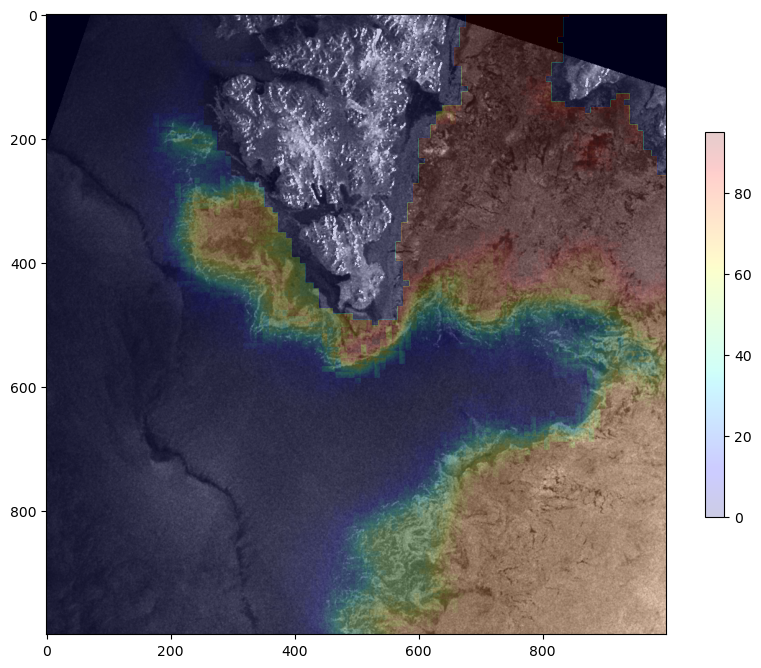

In [10]:
# plot collocated datasets
plt.figure(figsize=(10,10))
plt.imshow(Amplitude_HH_pro, cmap='gray', clim=[0,1000])
plt.imshow(ice_chart_pro, cmap='jet', alpha=0.2)
plt.colorbar(shrink=0.5)
plt.show()